In [1]:
import sys
sys.path.append('/Users/chadestep/GitHub/surmeierlab/neurphys/')

In [2]:
# because we made it, and it's awesome
import neurphys as nu

# because we always use them
import os
import time
import itertools
from glob import glob
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.sandbox.stats.multicomp
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
plt.style.use('estep_style')

In [231]:
# Gather all the files (only 3 this time around, all example traces), import them and correct for LJP

base_direc = '/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/RAW_DATA/SOP_uncaging_examples/'
file_paths = glob(base_direc+'*.abf')
file_names = [path.split('/')[-1].split('.')[0] for path in file_paths]
names_paths = list(zip(file_names,file_paths))

df_dict = {}

for name,path in names_paths:
    # read in all files, correct for "Modified Shen peforated patch internal" LJP, and store them in a dictionary
    df = nu.read_abf(path)
    df['primary'] -= 5.1
    df_dict[name] = df
df_dict.keys()

dict_keys(['2015_02_25_0003', '2015_03_19_0012', '2015_04_08_0008'])

In [14]:
# Cut each df into epochs, run periodogram on each
epoch_df = {}
pgram_df = {}
hist_df = {}
window = 2**15
step = 10**4

for cell,df in tqdm(df_dict.items()):   
    # make the epochs
    epoch_df[cell] = nu.oscillation.create_epoch(df,window,step)
    # analyze the epochs
    pgram_df[cell] = nu.oscillation.epoch_pgram(epoch_df[cell],'primary') 
    hist_df[cell] = nu.oscillation.epoch_hist(epoch_df[cell],'primary',-90,-30,60) 

100%|██████████| 4/4 [00:16<00:00,  4.57s/it]


(60, 67)
(60, 67)


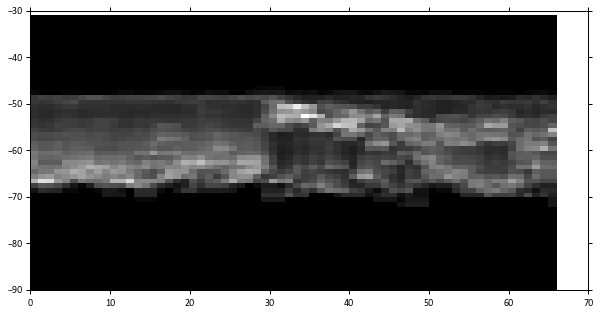

In [246]:
# testing out the pcolormesh figure
sweep_num = len(hist_df['2015_02_25_0003'].index.levels[0].values)
epoch_num = len(hist_df['2015_02_25_0003'].index.levels[1].values)
bin_num   = len(hist_df['2015_02_25_0003'].index.levels[2].values)
df = hist_df['2015_02_25_0003']

X,Y = np.meshgrid(np.arange(epoch_num),
#                   df.xs(('sweep001','epoch001'), level=('sweep','epoch'))['bin'])
                  df['bin'].unique())
print(X.shape)
print(Y.shape)

# C = hist_df['2015_02_25_0003']['primary'].xs('sweep001').values.reshape(67,60).T
C = df.xs('sweep001')['primary'].unstack().T

# gray, bone, hot, afmhot
plt.pcolormesh(X,Y,C,cmap='gray')
plt.show()

In [245]:
# df.xs(('sweep001','epoch001'), level=('sweep','epoch'))['bin']
# df.index.levels[2].values
df['bin'].unique()

array([-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80.,
       -79., -78., -77., -76., -75., -74., -73., -72., -71., -70., -69.,
       -68., -67., -66., -65., -64., -63., -62., -61., -60., -59., -58.,
       -57., -56., -55., -54., -53., -52., -51., -50., -49., -48., -47.,
       -46., -45., -44., -43., -42., -41., -40., -39., -38., -37., -36.,
       -35., -34., -33., -32., -31.])

In [205]:
# df = pgram_df['2015_02_25_0003']
# df_trimmed = df[df['frequency'] < 12]
# sweeps = df.index.levels[0].values
# epochs = df.index.levels[1].values
# freq = df['frequency']
# sweep_num = len(sweeps)
# epoch_num = len(epochs)
# freq_num  = len(freq)

# f,ax = plt.subplots(sweep_num,figsize=(10,sweep_num*3),sharey=True)
# for i,sweep in enumerate(sweeps):
#     X,Y = np.meshgrid(np.arange(epoch_num),
#                   df_trimmed.xs(('sweep001','epoch001'), level=('sweep','epoch'))['frequency'])
#     C = df_trimmed.xs(sweep)['primary'].unstack().T
#     ax[i].pcolormesh(X,Y,C,cmap='afmhot')
# ax[0].set_ylim(0,5)
# nu.nuplot.simple_figure(f)
# plt.show()

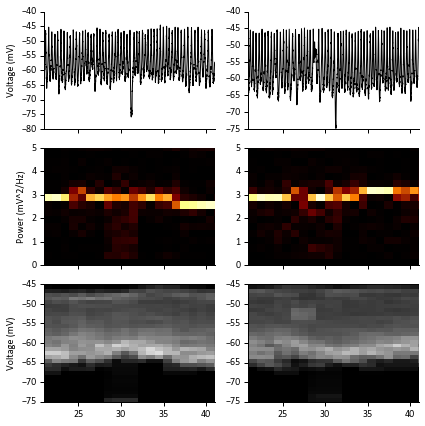

In [230]:
cell = '2015_02_25_0003'
# cell = '2015_03_19_0012'
# cell = '2015_04_08_0008'
df_ex = df_dict[cell]
df_pgram = pgram_df[cell][pgram_df[cell]['frequency'] < 12]
df_hist = hist_df[cell]
sweeps = df_pgram.index.levels[0].values
epochs = df_pgram.index.levels[1].values
sweep_num = len(sweeps)
epoch_num = len(epochs)

f,ax = plt.subplots(3,sweep_num,figsize=(sweep_num*3,6),sharex=True)

for i,sweep in enumerate(sweeps):
    ax[0,i].plot(df_ex.xs(sweep)['time'][::20],df_ex.xs(sweep)['primary'][::20])
for i,sweep in enumerate(sweeps):
    X,Y = np.meshgrid(np.arange(epoch_num),
                  df_pgram.xs(('sweep001','epoch001'), level=('sweep','epoch'))['frequency'])
    C = df_pgram.xs(sweep)['primary'].unstack().T
    ax[1,i].pcolormesh(X,Y,C,cmap='afmhot')
    ax[1,i].set_ylim(0,5)
for i,sweep in enumerate(sweeps):
    X,Y = np.meshgrid(np.arange(epoch_num),
                  df_hist.xs(('sweep001','epoch001'), level=('sweep','epoch'))['bin'])
    C = df_hist.xs(sweep)['primary'].unstack().T
    ax[2,i].pcolormesh(X,Y,C,cmap='gray')
    ax[2,i].set_ylim(-75,-45)
    
ax[0,0].set_xlim(21,41)     # <-- CONTROLS ALL X-LIMITS
ax[0,0].set_ylabel('Voltage (mV)')
ax[1,0].set_ylabel('Power (mV^2/Hz)')
ax[2,0].set_ylabel('Voltage (mV)')
nu.nuplot.simple_figure(f)
plt.tight_layout()
# save_direc = '/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/Thesis Projects/3 - GABA/Thesis/figures/'
# filename = '{0}.pdf'.format(cell)
# f.savefig(save_direc+filename,bbox_inches='tight',pad_inches=0)
plt.show()

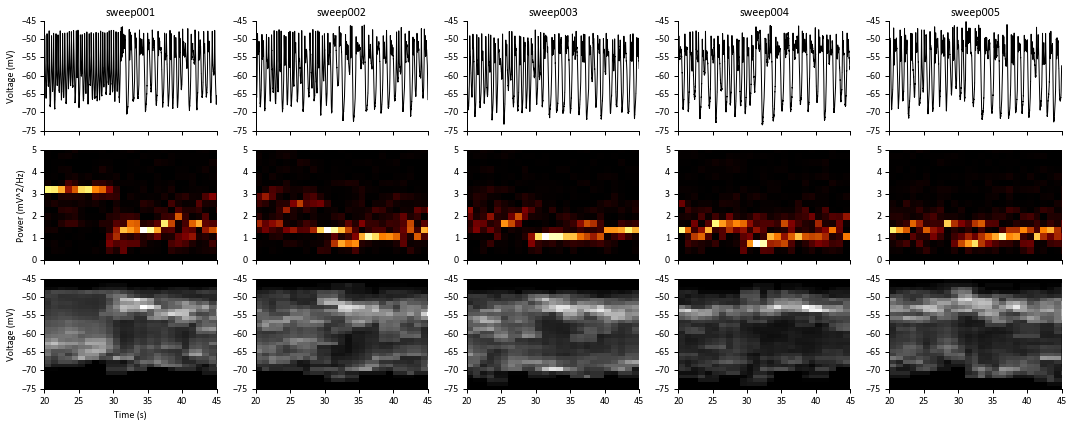

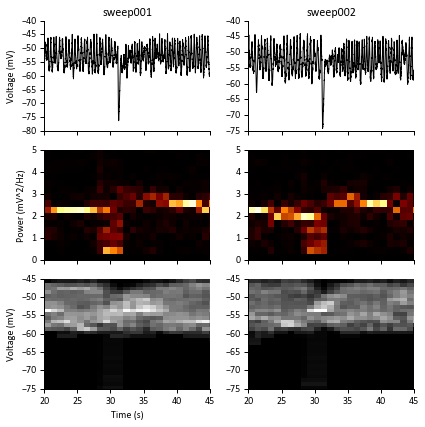

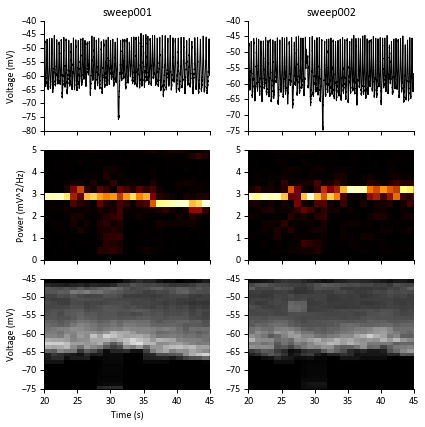

In [238]:
for cell in df_dict.keys():
    df_ex = df_dict[cell]
    df_pgram = pgram_df[cell][pgram_df[cell]['frequency'] < 12]
    df_hist = hist_df[cell]
    sweeps = df_pgram.index.levels[0].values
    epochs = df_pgram.index.levels[1].values
    sweep_num = len(sweeps)
    epoch_num = len(epochs)

    f,ax = plt.subplots(3,sweep_num,figsize=(sweep_num*3,6),sharex=True)

    for i,sweep in enumerate(sweeps):
        ax[0,i].plot(df_ex.xs(sweep)['time'][::20],df_ex.xs(sweep)['primary'][::20])
        ax[0,i].set_title(sweep)
    for i,sweep in enumerate(sweeps):
        X,Y = np.meshgrid(np.arange(epoch_num),
                      df_pgram.xs(('sweep001','epoch001'), level=('sweep','epoch'))['frequency'])
        C = df_pgram.xs(sweep)['primary'].unstack().T
        ax[1,i].pcolormesh(X,Y,C,cmap='afmhot')
        ax[1,i].set_ylim(0,5)
    for i,sweep in enumerate(sweeps):
        X,Y = np.meshgrid(np.arange(epoch_num),
                      df_hist.xs(('sweep001','epoch001'), level=('sweep','epoch'))['bin'])
        C = df_hist.xs(sweep)['primary'].unstack().T
        ax[2,i].pcolormesh(X,Y,C,cmap='gray')
        ax[2,i].set_ylim(-75,-45)

    ax[0,0].set_xlim(20,45)     # <-- CONTROLS ALL X-LIMITS
    ax[2,0].set_xlabel('Time (s)')
    ax[0,0].set_ylabel('Voltage (mV)')
    ax[1,0].set_ylabel('Power (mV^2/Hz)')
    ax[2,0].set_ylabel('Voltage (mV)')
    
    nu.nuplot.simple_figure(f)
    plt.tight_layout()
#     save_direc = '/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/Thesis Projects/3 - GABA/Thesis/figures/'
#     filename = '{0}.pdf'.format(cell)
#     f.savefig(save_direc+filename,bbox_inches='tight',pad_inches=0)

# Let's get all the data, normalize it, and make some fun figures.

In [ ]:
# Gather all the files (only 3 this time around, all example traces), import them and correct for LJP

base_direc = '/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/RAW_DATA/SOP_uncaging_all/'
file_paths = glob(base_direc+'*.abf')
file_names = [path.split('/')[-1].split('.')[0] for path in file_paths]
names_paths = list(zip(file_names,file_paths))

df_dict = {}

for name,path in names_paths:
    # read in all files, correct for "Modified Shen peforated patch internal" LJP, and store them in a dictionary
    df = nu.read_abf(path)
    df['primary'] -= 5.1
    df_dict[name] = df
df_dict.keys()

In [ ]:
# NORMALIZE DATA
# Power: normalize to average peak power of baseline
# Voltage: normalize to min/max range of baseline

'''
This will best be done using the AHP notebook way where I split everything up and compare it to the baseline.
'''